In [1]:
import numpy as np
import gym
import time
import math
import random
import torch
from torch.autograd import Variable
from tqdm import tqdm
import copy
from IPython.display import clear_output
from matplotlib import image
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns

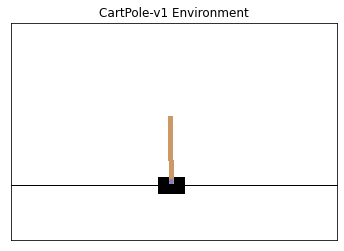

In [2]:
env = gym.envs.make("CartPole-v1")

def get_screen(screen=None):
    ''' Extract one step of the simulation.'''
    if screen is None:
        screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

# Speify the number of simulation steps
num_steps = 10

# Show several steps
for i in range(num_steps):
    clear_output(wait=True)
    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.title('CartPole-v1 Environment')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [3]:
observation, reward, done, info = env.step(env.action_space.sample())

In [75]:
math.sin(math.radians(120))

0.8660254037844387

In [5]:
# Demonstration
import matplotlib.pyplot as plt

env = gym.envs.make("CartPole-v1")

def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [6]:
class DQL():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim)
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.target = copy.deepcopy(self.model)

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

In [7]:
def q_learning(env, model, episodes, gamma=0.9, epsilon=0.3, eps_decay=0.99, replay=False, replay_size=20, title = 'DQL', double=False, n_update=10, soft=False):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    for episode in range(episodes):
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break
                if replay:
                    # Update network weights using replay memory
                    model.replay(memory, replay_size, gamma)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)
            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
    return final

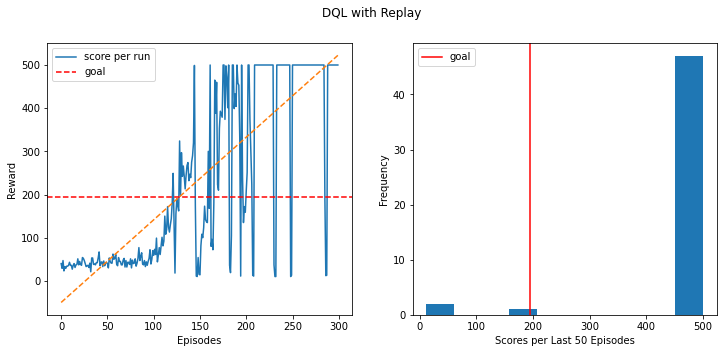

In [122]:
env = gym.envs.make("CartPole-v1")
model = DQL(state_dim=4, action_dim=2, hidden_dim=50, lr=0.001)
final = q_learning(env, model, episodes=300,
                   gamma=1.0, epsilon=0.2, replay=False, double=False,
                   title='DQL with Replay', n_update=20)

In [123]:
state = env.reset()
model.predict(state)

tensor([569.6754, 555.4532])

In [135]:
df = pd.DataFrame()
episodes = 1000
epsilon = 0.1
for i in tqdm(range(episodes)):
    done = False
    state = env.reset()
    t=0
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = model.predict(state).argmax().item()
        df = df.append({'episode': i, 't': t,'Cart Position': state[0], 'Cart Velocity': state[1], 'Pole Angle': state[2], 'Pole Angular Velocity': state[3], 'A': action}, ignore_index=True)
        state, reward, done, _ = env.step(action)
        t += 1

100%|██████████| 1000/1000 [26:41<00:00,  1.60s/it]


In [8]:
# df.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data.csv", index=False)
df = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data.csv")

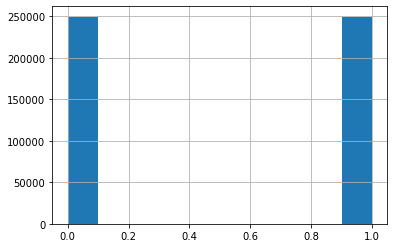

In [9]:
df['A'].hist()

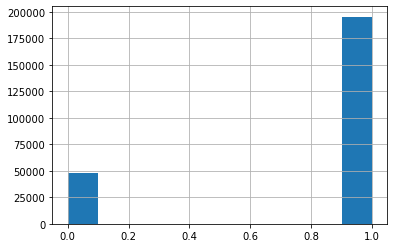

In [10]:
# df.loc[(df['Pole Angular Velocity']>0) & (df['Cart Velocity']>0), 'A'].hist()
df.loc[(df['Pole Angular Velocity']>0), 'A'].hist()

In [237]:
df.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity,episode,t
0,0.0,-0.044931,0.005088,0.000109,-0.033541,0.0,0.0
1,1.0,-0.044829,-0.190036,-0.000562,0.259176,0.0,1.0
2,0.0,-0.048630,0.005094,0.004621,-0.033684,0.0,2.0
3,1.0,-0.048528,-0.190094,0.003948,0.260453,0.0,3.0
4,0.0,-0.052330,0.004971,0.009157,-0.030982,0.0,4.0


In [148]:
PATH="/data/localhost/taufiq/export-dir/cartpole/cartpole_state_dicts"
torch.save({
    'model_state_dict': model.model.state_dict(),
    'optimizer_state_dict': model.optimizer.state_dict()
}, PATH)

# Remove the sign of angular velocity

We define the unobserved confounder $U$ to be the sign of Angular velocity

In [238]:
df_partial = df.copy()
df_partial['Pole Angular Velocity (sign)'] = (df_partial['Pole Angular Velocity']>=0)*1 - (df_partial['Pole Angular Velocity']<0)*1
df_partial['Cart Velocity (sign)'] = (df_partial['Cart Velocity']>=0)*1 - (df_partial['Cart Velocity']<0)*1
df_partial['Pole Angular Velocity'] = df_partial['Pole Angular Velocity'].abs()
df_partial['Cart Velocity'] = df_partial['Cart Velocity'].abs()
df_partial.rename(columns={'Pole Angular Velocity': 'Pole Angular Velocity (abs)', 'Cart Velocity': 'Cart Velocity (abs)'}, inplace=True)
df_partial.head()


,A,Cart Position,Cart Velocity (abs),Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Velocity (sign)
0,0.0,-0.044931,0.005088,0.000109,0.033541,0.0,0.0,-1,1
1,1.0,-0.044829,0.190036,-0.000562,0.259176,0.0,1.0,1,-1
2,0.0,-0.048630,0.005094,0.004621,0.033684,0.0,2.0,-1,1
3,1.0,-0.048528,0.190094,0.003948,0.260453,0.0,3.0,1,-1
4,0.0,-0.052330,0.004971,0.009157,0.030982,0.0,4.0,-1,1


In [9]:
x_columns = ['Cart Position', 'Cart Velocity (abs)', 'Pole Angle', 'Pole Angular Velocity (abs)']
rename_cols_t1 = {k: f'{k}_t1' for k in x_columns}

In [240]:
# sim_data = pd.DataFrame()
# for episode in tqdm(range(0,500)):
#     df_filtered_t0 = df_partial.loc[df_partial['episode']==episode].copy().iloc[:-1].reset_index(drop=True)
#     df_filtered_t1 = df_partial.loc[df_partial['episode']==episode].copy().iloc[1:][x_columns].rename(columns=rename_cols_t1).reset_index(drop=True)
#     df_episode = pd.merge(df_filtered_t0, df_filtered_t1, left_index=True, right_index=True)
#     sim_data = sim_data.append(df_episode, ignore_index=True)

100%|██████████| 500/500 [00:03<00:00, 129.76it/s]


In [241]:
obs_data = pd.DataFrame()
for episode in tqdm(range(500,1000)):
    df_filtered_t0 = df_partial.loc[df_partial['episode']==episode].copy().iloc[:-1].reset_index(drop=True)
    df_filtered_t1 = df_partial.loc[df_partial['episode']==episode].copy().iloc[1:][x_columns].rename(columns=rename_cols_t1).reset_index(drop=True)
    df_episode = pd.merge(df_filtered_t0, df_filtered_t1, left_index=True, right_index=True)
    obs_data = obs_data.append(df_episode, ignore_index=True)

100%|██████████| 500/500 [00:03<00:00, 129.45it/s]


In [242]:
quantile_data = sim_data.copy()

In [243]:
len(obs_data)

249500

# Confounding
To induce confounding, we only include transitions with angular velocity <= 0 in observational data.

In [244]:
# select = np.random.uniform(0, 1, len(sim_data))
# sim_data_filtered = sim_data.loc[select < 0.5]


In [245]:
select = np.random.uniform(0, 1, len(obs_data))
obs_data = obs_data.loc[~(obs_data['Pole Angular Velocity (sign)']>0)]


In [374]:
len(obs_data)

126311

In [247]:
random_arr = np.random.uniform(0, 1, len(obs_data))
obs_data_train = obs_data[random_arr <= 0.8].copy()
obs_data_test = obs_data[random_arr > 0.8].copy()

In [248]:
(sim_data_filtered['Pole Angular Velocity (sign)']==-1).sum()

64188

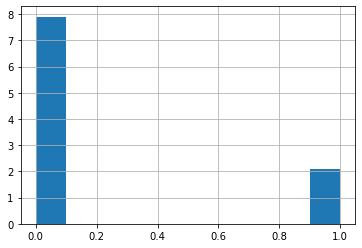

In [249]:
obs_data_train['A'].hist(density=True)

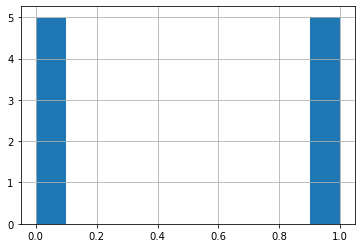

In [250]:
sim_data_filtered['A'].hist(density=True)

# Generate $Y(a)$ Data using random policy

In [6]:
sim_data = pd.DataFrame()
episodes = 4000
for i in tqdm(range(episodes)):
    done = False
    state = env.reset()
    t=0
    while not done:
        action = env.action_space.sample()
        sim_data = sim_data.append({'episode': i, 't': t,'Cart Position': state[0], 'Cart Velocity': state[1], 'Pole Angle': state[2], 'Pole Angular Velocity': state[3], 'A': action}, ignore_index=True)
        state, reward, done, _ = env.step(action)
        t += 1

100%|██████████| 4000/4000 [01:41<00:00, 39.50it/s]


In [14]:
len(sim_data)

88781

In [8]:
sim_data['Pole Angular Velocity (sign)'] = (sim_data['Pole Angular Velocity']>=0)*1 - (sim_data['Pole Angular Velocity']<0)*1
sim_data['Cart Velocity (sign)'] = (sim_data['Cart Velocity']>=0)*1 - (sim_data['Cart Velocity']<0)*1
sim_data['Pole Angular Velocity'] = sim_data['Pole Angular Velocity'].abs()
sim_data['Cart Velocity'] = sim_data['Cart Velocity'].abs()
sim_data.rename(columns={'Pole Angular Velocity': 'Pole Angular Velocity (abs)', 'Cart Velocity': 'Cart Velocity (abs)'}, inplace=True)
sim_data.head()

,A,Cart Position,Cart Velocity (abs),Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Velocity (sign)
0,0.0,-0.015216,0.043768,-0.045269,0.003688,0.0,0.0,1,-1
1,0.0,-0.016091,0.238212,-0.045195,0.281751,0.0,1.0,1,-1
2,0.0,-0.020855,0.432661,-0.039560,0.559844,0.0,2.0,1,-1
3,0.0,-0.029509,0.627206,-0.028363,0.839805,0.0,3.0,1,-1
4,1.0,-0.042053,0.821930,-0.011567,1.123435,0.0,4.0,1,-1


In [10]:
episodes = sim_data['episode'].unique()
sim_data_combined = pd.DataFrame()
for episode in tqdm(episodes):
    df_filtered_t0 = sim_data.loc[sim_data['episode']==episode].copy().iloc[:-1].reset_index(drop=True)
    df_filtered_t1 = sim_data.loc[sim_data['episode']==episode].copy().iloc[1:][x_columns].rename(columns=rename_cols_t1).reset_index(drop=True)
    df_episode = pd.merge(df_filtered_t0, df_filtered_t1, left_index=True, right_index=True)
    sim_data_combined = sim_data_combined.append(df_episode, ignore_index=True)
    

100%|██████████| 4000/4000 [00:16<00:00, 236.18it/s]


In [12]:
sim_data_combined.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-sim-data-rand-policy.csv", index=False)

In [375]:
# obs_data_train.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-train.csv", index=False)
# obs_data_test.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-test.csv", index=False)
# sim_data_filtered.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-sim-data.csv", index=False)

obs_data_train = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-train.csv")
obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-test.csv")
sim_data_filtered = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-sim-data-rand-policy.csv")

# Train policy $\pi(A\mid X)$

In [2]:
import torch.utils.data as data_utils

class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_1_dim=3):
        super(PolicyNetwork, self).__init__()
        self.hid1 = torch.nn.Linear(input_dim, hidden_1_dim)
        self.outp = torch.nn.Linear(hidden_1_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.outp.weight)
        torch.nn.init.zeros_(self.outp.bias)

    def forward(self, x):
        z = self.tanh(self.hid1(x))
        z = self.outp(z)
        return z

In [252]:
obs_data_raw = (obs_data_train[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [253]:
grp = np.floor(5*np.random.rand(len(obs_data_train))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(obs_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(obs_data_raw.loc[testidx].values)
Y = torch.tensor(obs_data_train.loc[trainidx, 'A'].values).to(torch.long)
Ytest = torch.tensor(obs_data_train.loc[testidx, 'A'].values).to(torch.long)

train = data_utils.TensorDataset(X, Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(Xtest, Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=len(obs_data_raw.columns), output_dim=2)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.01)
losses = []

In [258]:
for epoch in tqdm(range(50)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


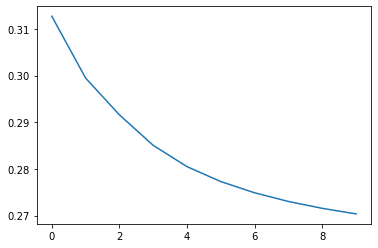

In [259]:
plt.plot(losses)

In [260]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(Xtest)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += Xtest.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 92 %


In [261]:
PATH="/data/localhost/taufiq/export-dir/cartpole/policy_dicts"
torch.save({
    'model_state_dict': policy.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

In [30]:
checkpoint = torch.load(PATH)
policy.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Train $\mathbb{E}[Y \mid x, a]$

In [12]:
outcome = "Pole Angle"

In [3]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [264]:
grp = np.floor(5*np.random.rand(len(obs_data_train))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(obs_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(obs_data_raw.loc[testidx].values)
A = torch.FloatTensor(obs_data_train.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(obs_data_train.loc[testidx, 'A'].values)

Y = torch.FloatTensor((obs_data_train.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((obs_data_train.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.MSELoss()
obs_net = Net(n_feature=len(obs_data_raw.columns)+1, n_hidden=4, n_output=1)
optimizer = torch.optim.SGD(obs_net.parameters(), lr=0.01)
losses = []

In [265]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = obs_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(obs_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


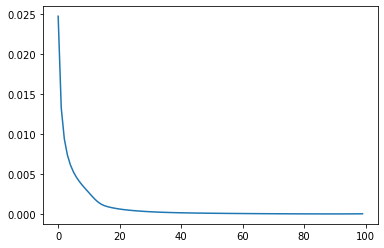

In [266]:
plt.plot(losses)

In [267]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_obs_dicts"
torch.save({
    'model_state_dict': obs_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

In [36]:
checkpoint = torch.load(PATH)
obs_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Train $\mathbb{E}[Y_{max}\mid x, a]$

In [4]:
class PinballLoss():
    def __init__(self, quantile=0.10, reduction='none'):
        self.quantile = quantile
        assert 0 < self.quantile
        assert self.quantile < 1
        self.reduction = reduction

    def __call__(self, output, target):
        assert output.shape == target.shape
        loss = torch.zeros_like(target, dtype=torch.float)
        error = output - target
        smaller_index = error < 0
        bigger_index = 0 < error
        loss[smaller_index] = self.quantile * (abs(error)[smaller_index])
        loss[bigger_index] = (1-self.quantile) * (abs(error)[bigger_index])

        if self.reduction == 'sum':
            loss = loss.sum()
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [326]:
quantile_data_raw = (quantile_data[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [327]:
grp = np.floor(5*np.random.rand(len(quantile_data))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(quantile_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(quantile_data_raw.loc[testidx].values)
A = torch.FloatTensor(quantile_data.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(quantile_data.loc[testidx, 'A'].values)

Y = torch.FloatTensor((quantile_data.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((quantile_data.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = PinballLoss(quantile=0.99999, reduction='mean')
ymax_net = Net(n_feature=len(quantile_data_raw.columns)+1, n_hidden=4, n_output=1)
optimizer = torch.optim.SGD(ymax_net.parameters(), lr=0.001)
losses = []

In [328]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = ymax_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(ymax_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [05:41<00:00,  3.42s/it]


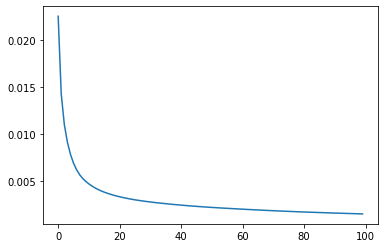

In [329]:
plt.plot(losses)

In [330]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_max_dicts"
torch.save({
    'model_state_dict': ymax_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

# Train $\mathbb{E}[Y_{min}\mid x, a]$

In [331]:
loss_func = PinballLoss(quantile=0.00001, reduction='mean')
ymin_net = Net(n_feature=len(quantile_data_raw.columns)+1, n_hidden=4, n_output=1)
optimizer = torch.optim.SGD(ymin_net.parameters(), lr=0.001)
losses = []

In [332]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = ymin_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(ymin_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [05:41<00:00,  3.42s/it]


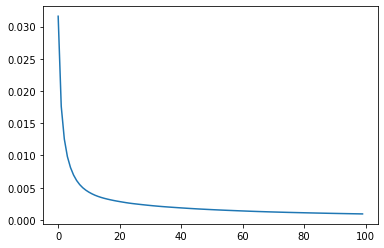

In [333]:
plt.plot(losses)

In [334]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_min_dicts"
torch.save({
    'model_state_dict': ymax_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

# Train $\mathbb{E}[Y^{sim}(a) \mid x(a)]$

In [279]:
sim_data_raw = (sim_data_filtered[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()


In [280]:
grp = np.floor(5*np.random.rand(len(sim_data_filtered))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(sim_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(sim_data_raw.loc[testidx].values)
A = torch.FloatTensor(sim_data_filtered.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(sim_data_filtered.loc[testidx, 'A'].values)

Y = torch.FloatTensor((sim_data_filtered.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((sim_data_filtered.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.MSELoss()
sim_net = Net(n_feature=len(sim_data_raw.columns)+1, n_hidden=4, n_output=1)
optimizer = torch.optim.SGD(sim_net.parameters(), lr=0.01)
losses = []

In [291]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = sim_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(sim_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


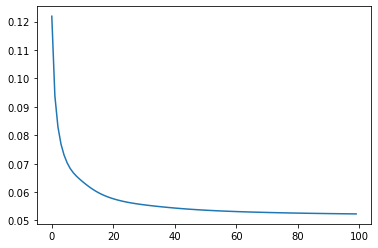

In [292]:
plt.plot(losses)

In [293]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_sim_dicts"
torch.save({
    'model_state_dict': sim_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

In [40]:
checkpoint = torch.load(PATH)
sim_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [41]:
sim_data.head()

,A,Cart Position,Cart Velocity,Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Position_t1,Cart Velocity_t1,Pole Angle_t1,Pole Angular Velocity (abs)_t1
0,0.0,-0.044931,0.005088,0.000109,0.033541,0.0,0.0,-1,-0.044829,-0.190036,-0.000562,0.259176
1,1.0,-0.044829,-0.190036,-0.000562,0.259176,0.0,1.0,1,-0.048630,0.005094,0.004621,0.033684
2,0.0,-0.048630,0.005094,0.004621,0.033684,0.0,2.0,-1,-0.048528,-0.190094,0.003948,0.260453
3,1.0,-0.048528,-0.190094,0.003948,0.260453,0.0,3.0,1,-0.052330,0.004971,0.009157,0.030982
4,0.0,-0.052330,0.004971,0.009157,0.030982,0.0,4.0,-1,-0.052230,-0.190281,0.008537,0.264576


# Compare MSE with Scores

In [335]:
obs_data_test_raw = (obs_data_test[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [336]:
obs_data_test_copy = obs_data_test.copy()
with torch.no_grad():
    X_val = torch.FloatTensor(obs_data_test_raw.values) 
    A_val = torch.FloatTensor(obs_data_test['A'].values)
    pred = obs_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    sim_pred = sim_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    Y = torch.FloatTensor(obs_data_test[f'{outcome}_t1'].values)
    mse = torch.square(sim_pred - Y)
    pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]
    ymin = ymin_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    ymax = ymax_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    obs_data_test_copy['MSE'] = mse.numpy()
    obs_data_test_copy['LB'] = (pred*pol_val + (1-pol_val)*ymin).numpy()
    obs_data_test_copy['UB'] = (pred*pol_val + (1-pol_val)*ymax).numpy()
    obs_data_test_copy[f'Sim_{outcome}_t1'] = sim_pred.numpy()
    obs_data_test_copy['In bounds'] = (obs_data_test_copy['LB'] <= obs_data_test_copy[f'Sim_{outcome}_t1']).apply(int) * (obs_data_test_copy['UB'] >= obs_data_test_copy[f'Sim_{outcome}_t1']).apply(int)
    obs_data_test_copy['Bound length'] = obs_data_test_copy['UB'] - obs_data_test_copy['LB']
    

In [337]:
obs_data_test_copy.head()

,A,Cart Position,Cart Velocity (abs),Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Velocity (sign),Cart Position_t1,Cart Velocity (abs)_t1,Pole Angle_t1,Pole Angular Velocity (abs)_t1,MSE,LB,UB,Sim_Pole Angle_t1,In bounds,Bound length
6,0.0,0.017909,0.027689,-0.004355,0.048940,500.0,6.0,-1,-1,0.017355,0.222748,-0.005334,0.242365,1.077220e-06,-0.006164,-0.004801,-0.004296,0,0.001363
12,0.0,-0.004923,0.028104,0.018981,0.039786,500.0,12.0,-1,-1,-0.005485,0.223493,0.018185,0.258825,2.935338e-07,0.008318,0.056401,0.017644,1,0.048083
27,0.0,-0.002272,0.163339,0.003266,0.251321,500.0,27.0,-1,1,0.000995,0.031829,-0.001760,0.042390,1.540385e-08,-0.003011,0.000175,-0.001884,1,0.003186
33,0.0,-0.002180,0.163466,0.002310,0.254127,500.0,33.0,-1,1,0.001089,0.031688,-0.002773,0.039284,1.983366e-08,-0.004178,-0.000719,-0.002913,1,0.003459
37,0.0,0.010897,0.163602,-0.018024,0.257135,500.0,37.0,-1,1,0.014169,0.031259,-0.023167,0.029809,2.421941e-06,-0.025916,-0.021757,-0.021610,0,0.004159


In [338]:
obs_data_test_copy.loc[obs_data_test_copy['A']==0, 'MSE'].mean()

1.544829274280346e-06

In [339]:
obs_data_test_copy.loc[obs_data_test_copy['A']==1, 'MSE'].mean()

1.7826389012043364e-05

In [345]:
p0 = ((obs_data_test_copy['In bounds']==1) & (obs_data_test_copy['A']==0)).sum()/(obs_data_test_copy['A']==0).sum()
p1 = ((obs_data_test_copy['In bounds']==1) & (obs_data_test_copy['A']==1)).sum()/(obs_data_test_copy['A']==1).sum()
print(f'p_0 = {p0}$')
print(f'p_1 = {p1}$')

p_0 = 0.8034591194968553$
p_1 = 0.9549772036474165$


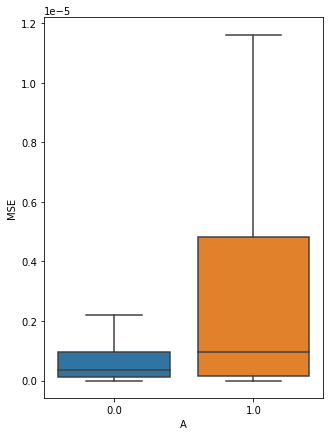

In [346]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(5,7))
sns.boxplot(y='MSE',x='A', data=obs_data_test_copy.astype({'A': 'str'}), ax=axs, showfliers=False)

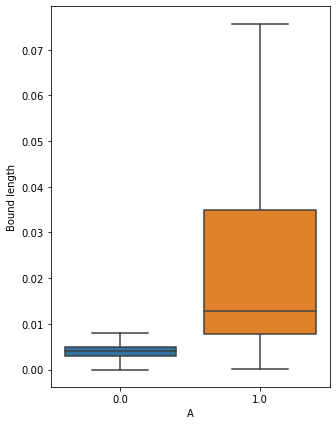

In [347]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(5,7))
sns.boxplot(y='Bound length',x='A', data=obs_data_test_copy.astype({'A': 'str'}), ax=axs, showfliers=False)

# Simulator 2: wrong model

Simulator 2 is wrong but should attain lower MSE than previous simulator

In [359]:
sim2_data = sim_data_filtered.copy()

In [360]:
epsilon = 0.0015
sim2_data.loc[:,'Pole Angle_t1'] -= epsilon

In [376]:
sim2_data.head()

,A,Cart Position,Cart Velocity (abs),Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Velocity (sign),Cart Position_t1,Cart Velocity (abs)_t1,Pole Angle_t1,Pole Angular Velocity (abs)_t1
0,0.0,-0.044931,0.005088,0.000109,0.033541,0.0,0.0,-1,1,-0.044829,0.190036,-0.002062,0.259176
1,1.0,-0.044829,0.190036,-0.000562,0.259176,0.0,1.0,1,-1,-0.048630,0.005094,0.003121,0.033684
6,1.0,-0.056036,0.004718,0.013829,0.025402,0.0,6.0,-1,1,-0.055942,0.199639,0.011821,0.313690
8,1.0,-0.051949,0.004330,0.007047,0.016836,0.0,8.0,-1,1,-0.051862,0.199350,0.005210,0.307287
9,0.0,-0.051862,0.199350,0.006710,0.307287,0.0,9.0,-1,1,-0.047875,0.004134,-0.000936,0.012496


In [377]:
sim2_data.to_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-sim2-data.csv", index=False)

# Train $\mathbb{E}[Y^{sim2}(a) \mid x(a)]$

In [362]:
sim2_data_raw = (sim2_data[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

In [363]:
grp = np.floor(5*np.random.rand(len(sim2_data))+1)
crossval = 1
trainidx = (grp != crossval)
testidx = (grp == crossval)
X = torch.FloatTensor(sim2_data_raw.loc[trainidx].values)
Xtest = torch.FloatTensor(sim2_data_raw.loc[testidx].values)
A = torch.FloatTensor(sim2_data.loc[trainidx, 'A'].values)
Atest = torch.FloatTensor(sim2_data.loc[testidx, 'A'].values)

Y = torch.FloatTensor((sim2_data.loc[trainidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)
Ytest = torch.FloatTensor((sim2_data.loc[testidx, f'{outcome}_t1'] - df_partial[outcome].mean()).values/df_partial[outcome].std()).unsqueeze(dim=1)

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtest, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.MSELoss()
sim2_net = Net(n_feature=len(sim2_data_raw.columns)+1, n_hidden=4, n_output=1)
optimizer = torch.optim.SGD(sim2_net.parameters(), lr=0.001)
losses = []

In [364]:
for epoch in tqdm(range(100)):
    for X, Y in trainloader:
        prediction = sim2_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(sim2_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


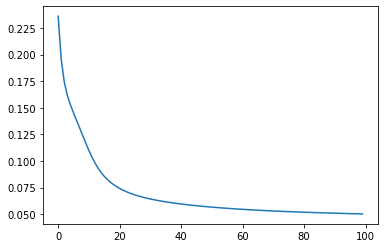

In [365]:
plt.plot(losses)

In [366]:
PATH="/data/localhost/taufiq/export-dir/cartpole/y_sim2_dicts"
torch.save({
    'model_state_dict': sim2_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, PATH)

In [367]:
obs_data_test_copy2 = obs_data_test.copy()
with torch.no_grad():
    X_val = torch.FloatTensor(obs_data_test_raw.values) 
    A_val = torch.FloatTensor(obs_data_test['A'].values)
    pred = obs_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    sim2_pred = sim2_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    Y = torch.FloatTensor(obs_data_test[f'{outcome}_t1'].values)
    mse = torch.square(sim2_pred - Y)
    pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]
    ymin = ymin_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    ymax = ymax_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
    obs_data_test_copy2['MSE'] = mse.numpy()
    obs_data_test_copy2['LB'] = (pred*pol_val + (1-pol_val)*ymin).numpy()
    obs_data_test_copy2['UB'] = (pred*pol_val + (1-pol_val)*ymax).numpy()
    obs_data_test_copy2[f'Sim2_{outcome}_t1'] = sim2_pred.numpy()
    obs_data_test_copy2['In bounds'] = (obs_data_test_copy2['LB'] <= obs_data_test_copy2[f'Sim2_{outcome}_t1']).apply(int) * (obs_data_test_copy2['UB'] >= obs_data_test_copy2[f'Sim2_{outcome}_t1']).apply(int)
    obs_data_test_copy2['Bound length'] = obs_data_test_copy2['UB'] - obs_data_test_copy2['LB']


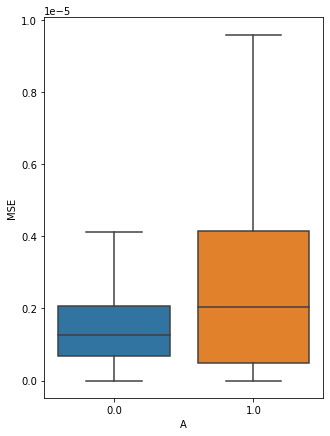

In [368]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(5,7))
sns.boxplot(y='MSE',x='A', data=obs_data_test_copy2.astype({'A': 'str'}), ax=axs, showfliers=False)

In [369]:
p0 = ((obs_data_test_copy2['In bounds']==1) & (obs_data_test_copy2['A']==0)).sum()/(obs_data_test_copy2['A']==0).sum()
p1 = ((obs_data_test_copy2['In bounds']==1) & (obs_data_test_copy2['A']==1)).sum()/(obs_data_test_copy2['A']==1).sum()
print(f'p_0={p0}')
print(f'p_1={p1}')


p_0=0.7025258673158856
p_1=0.9454787234042553


# Analysis of experiment results

In [16]:
nreps = 400
outcome = 'Pole Angle'
obs_data_train = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-train.csv")
df = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data.csv")
x_columns = ['Cart Position', 'Cart Velocity (abs)', 'Pole Angle', 'Pole Angular Velocity (abs)']


In [17]:
df_partial = df.copy()
df_partial['Pole Angular Velocity (sign)'] = (df_partial['Pole Angular Velocity']>=0)*1 - (df_partial['Pole Angular Velocity']<0)*1
df_partial['Cart Velocity (sign)'] = (df_partial['Cart Velocity']>=0)*1 - (df_partial['Cart Velocity']<0)*1
df_partial['Pole Angular Velocity'] = df_partial['Pole Angular Velocity'].abs()
df_partial['Cart Velocity'] = df_partial['Cart Velocity'].abs()
df_partial.rename(columns={'Pole Angular Velocity': 'Pole Angular Velocity (abs)', 'Cart Velocity': 'Cart Velocity (abs)'}, inplace=True)
df_partial.head()

,A,Cart Position,Cart Velocity (abs),Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Velocity (sign)
0,0.0,-0.044931,0.005088,0.000109,0.033541,0.0,0.0,-1,1
1,1.0,-0.044829,0.190036,-0.000562,0.259176,0.0,1.0,1,-1
2,0.0,-0.048630,0.005094,0.004621,0.033684,0.0,2.0,-1,1
3,1.0,-0.048528,0.190094,0.003948,0.260453,0.0,3.0,1,-1
4,0.0,-0.052330,0.004971,0.009157,0.030982,0.0,4.0,-1,1


In [18]:
obs_data_test = pd.read_csv("/data/localhost/taufiq/export-dir/Cartpole-v1-obs-data-test.csv")
obs_data_test['A'] = obs_data_test['A'].astype({'A': 'int'})
obs_data_test_raw = (obs_data_test[x_columns] - df_partial[x_columns].mean())/df_partial[x_columns].std()

obs_data_test['MSE (Sim-1)'] = 0
obs_data_test['MSE (Sim-2)'] = 0
obs_data_test['$\hat{p}^{x,a}$ (Sim-1)'] = 0
obs_data_test['$\hat{p}^{x,a}$ (Sim-2)'] = 0

for i in tqdm(range(nreps)):
    models_dir = "/data/localhost/taufiq/cartpole_sim_run1"
    policy = PolicyNetwork(input_dim=len(obs_data_test_raw.columns), output_dim=2)
    policy.load_state_dict(torch.load(f'{models_dir}/policy_{i}'))
    policy.eval()
    obs_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    obs_net.load_state_dict(torch.load(f'{models_dir}/yobs_{i}'))
    obs_net.eval()
    ymin_net = Net(n_feature=len(obs_data_test_raw.columns), n_hidden=4, n_output=1)
    ymin_net.load_state_dict(torch.load(f'{models_dir}/ymin_{i}'))
    ymin_net.eval()
    ymax_net = Net(n_feature=len(obs_data_test_raw.columns), n_hidden=4, n_output=1)
    ymax_net.load_state_dict(torch.load(f'{models_dir}/ymax_{i}'))
    ymax_net.eval()
    sim_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    sim_net.load_state_dict(torch.load(f'{models_dir}/ysim_{i}'))
    sim_net.eval()
    sim2_net = Net(n_feature=len(obs_data_test_raw.columns)+1, n_hidden=4, n_output=1)
    sim2_net.load_state_dict(torch.load(f'{models_dir}/ysim_false_{i}'))
    sim2_net.eval()
    
    with torch.no_grad():
        X_val = torch.FloatTensor(obs_data_test_raw.values) 
        A_val = torch.FloatTensor(obs_data_test['A'].values)
        pred = obs_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
        sim_pred = sim_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
        sim2_pred = sim2_net(torch.column_stack((X_val, A_val))).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
        Y = torch.FloatTensor(obs_data_test[f'{outcome}_t1'].values)
        mse = torch.square(sim_pred - Y)
        mse2 = torch.square(sim2_pred - Y)
        pol_val = torch.nn.Softmax(dim=1)(policy(X_val))[torch.arange(A_val.shape[0]), A_val.to(torch.long)]
        ymin = ymin_net(X_val).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()
        ymax = ymax_net(X_val).reshape(-1)*df_partial[outcome].std() + df_partial[outcome].mean()        
        obs_data_test['MSE (Sim-1)'] += mse.numpy()
        obs_data_test['MSE (Sim-2)'] += mse2.numpy()
        obs_data_test['LB'] = (pred*pol_val + (1-pol_val)*ymin).numpy()
        obs_data_test['UB'] = (pred*pol_val + (1-pol_val)*ymax).numpy()
        obs_data_test[f'Sim-1_{outcome}_t1'] = sim_pred.numpy()
        obs_data_test['$\hat{p}^{x,a}$ (Sim-1)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-1_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-1_{outcome}_t1']).apply(int)
        obs_data_test[f'Sim-2_{outcome}_t1'] = sim2_pred.numpy()
        obs_data_test['$\hat{p}^{x,a}$ (Sim-2)'] += (obs_data_test['LB'] <= obs_data_test[f'Sim-2_{outcome}_t1']).apply(int) * (obs_data_test['UB'] >= obs_data_test[f'Sim-2_{outcome}_t1']).apply(int)
        obs_data_test['Bound length'] = obs_data_test['UB'] - obs_data_test['LB']
    
obs_data_test['MSE (Sim-1)'] /= nreps
obs_data_test['MSE (Sim-2)'] /= nreps
obs_data_test['$\hat{p}^{x,a}$ (Sim-1)'] /= nreps
obs_data_test['$\hat{p}^{x,a}$ (Sim-2)'] /= nreps

100%|██████████| 400/400 [00:13<00:00, 30.76it/s]


In [19]:
obs_data_test.head()

,A,Cart Position,Cart Velocity (abs),Pole Angle,Pole Angular Velocity (abs),episode,t,Pole Angular Velocity (sign),Cart Velocity (sign),Cart Position_t1,...,Pole Angular Velocity (abs)_t1,MSE (Sim-1),MSE (Sim-2),"$\hat{p}^{x,a}$ (Sim-1)","$\hat{p}^{x,a}$ (Sim-2)",LB,UB,Sim-1_Pole Angle_t1,Sim-2_Pole Angle_t1,Bound length
0,0,0.017909,0.027689,-0.004355,0.048940,500.0,6.0,-1,-1,0.017355,...,0.242365,3.423991e-07,1.566448e-06,0.4850,0.1000,-0.005955,-0.004979,-0.005023,-0.006566,0.000977
1,0,-0.004923,0.028104,0.018981,0.039786,500.0,12.0,-1,-1,-0.005485,...,0.258825,4.807121e-07,2.197580e-06,1.0000,0.9850,-0.001569,0.048236,0.019127,0.016671,0.049804
2,0,-0.002272,0.163339,0.003266,0.251321,500.0,27.0,-1,1,0.000995,...,0.042390,2.718213e-07,1.509968e-06,0.9925,0.7425,-0.002902,-0.000424,-0.001795,-0.003149,0.002478
3,0,-0.002180,0.163466,0.002310,0.254127,500.0,33.0,-1,1,0.001089,...,0.039284,2.944044e-07,1.472656e-06,0.9925,0.7750,-0.003939,-0.001437,-0.002786,-0.004184,0.002502
4,0,0.010897,0.163602,-0.018024,0.257135,500.0,37.0,-1,1,0.014169,...,0.029809,3.943983e-06,7.147305e-07,0.2850,0.8875,-0.025247,-0.021914,-0.021266,-0.023140,0.003333


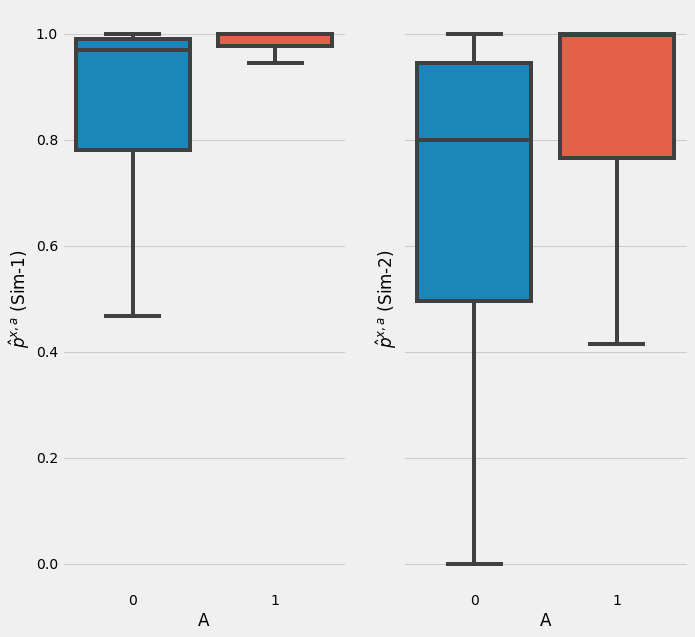

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10,10), sharey=True)
plt.style.use('fivethirtyeight')
sns.boxplot(y='$\hat{p}^{x,a}$ (Sim-1)',x='A', data=obs_data_test.astype({'A': 'str'}), ax=axs[0], showfliers=False)
sns.boxplot(y='$\hat{p}^{x,a}$ (Sim-2)',x='A', data=obs_data_test.astype({'A': 'str'}), ax=axs[1], showfliers=False)

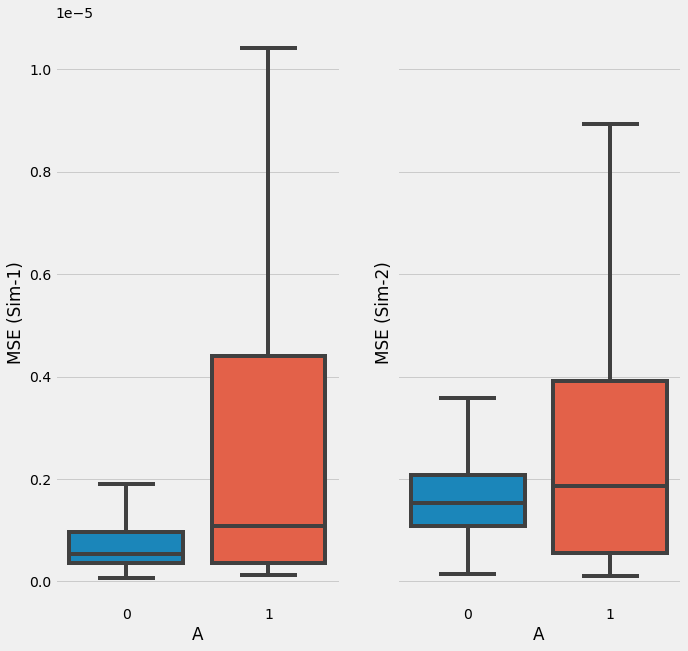

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10,10), sharey=True)
plt.style.use('fivethirtyeight')
sns.boxplot(y='MSE (Sim-1)',x='A', data=obs_data_test.astype({'A': 'str'}), ax=axs[0], showfliers=False)
sns.boxplot(y='MSE (Sim-2)',x='A', data=obs_data_test.astype({'A': 'str'}), ax=axs[1], showfliers=False)

# Plotting bounds on the simulator

In [324]:
# screen = env.render(mode='rgb_array').transpose((2, 0, 1))
# np.save("/data/localhost/taufiq/export-dir/cartpole_env", screen)

In [2]:
screen = np.load("/data/localhost/taufiq/export-dir/cartpole_env.npy")

Text(0.5, 1.0, 'Action 1')

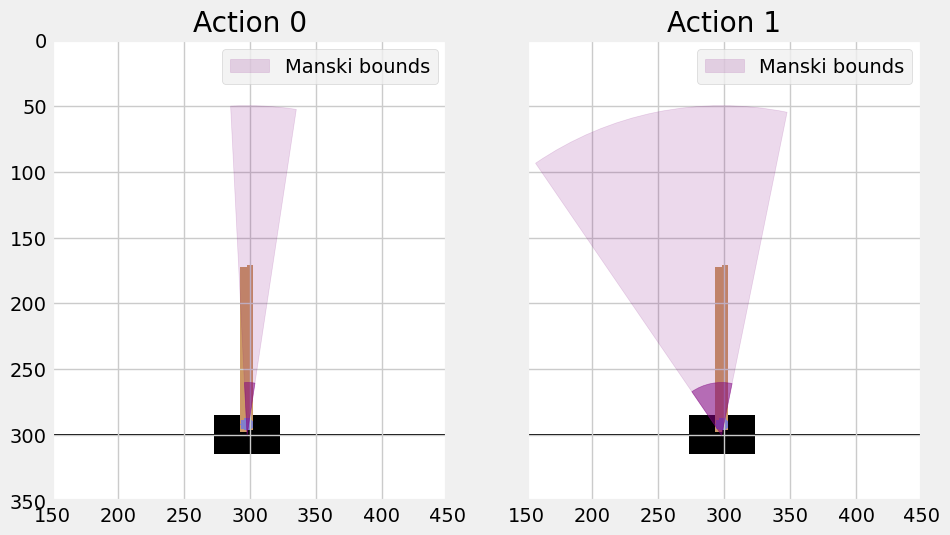

In [28]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

def filled_arc(center, radius, theta1, theta2, ax, color):

    circ = mpatches.Wedge(center, radius, theta1*180/np.pi, theta2*180/np.pi, fill=True, color=color, alpha=0.15)
    circ2 = mpatches.Wedge(center, 40, theta1*180/np.pi, theta2*180/np.pi, fill=True, color=color, alpha=0.5)
    pt1 = (radius * (np.cos(theta1)) + center[0],
           radius * (np.sin(theta1)) + center[1])
    pt2 = (radius * (np.cos(theta2)) + center[0],
           radius * (np.sin(theta2)) + center[1])
    pt3 = center
    pol = mpatches.Polygon([pt1, pt2, pt3], lw=2)
    ax.add_patch(circ)
    ax.add_patch(circ2)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,10))
ax[0].imshow(get_screen(screen).cpu().permute(1, 2, 0).numpy(), interpolation='none')
ax[1].imshow(get_screen(screen).cpu().permute(1, 2, 0).numpy(), interpolation='none')
filled_arc((298,300), 250, 3*np.pi/2 - 0.05, 3*np.pi/2 + 0.15, ax[0], "purple")
plt.style.use('fivethirtyeight')
ax[0].legend(['Manski bounds'])
ax[0].set_xlim([150, 450])
ax[0].set_ylim([350, 0])
ax[0].set_title('Action 0')
filled_arc((298,300), 250, 3*np.pi/2 - 0.6, 3*np.pi/2 + 0.2, ax[1], "purple")
ax[1].set_xlim([150, 450])
ax[1].set_ylim([350, 0])
ax[1].legend(['Manski bounds'])
ax[1].set_title('Action 1')
